In [1]:
import numpy as np
#load data from file导入txt数据
def load_data(filename):
    dataset = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split('\t')
        m = len(lineArr)
        dataset.append(lineArr[0:m])
    return np.array(dataset,dtype=np.float64)
           


In [2]:
import matplotlib.pyplot as plt
x = load_data("testSet.txt")
print (x.shape)

#可视化一下
plt.scatter(x[:,0],x[:,1],marker='x',color = 'r')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

(80, 2)


<Figure size 640x480 with 1 Axes>

In [3]:
#计算距离
def computeDistance(A,B):
    return np.sqrt(np.sum(np.square(A-B)))

#我们一开始应该随机初始化centroids ,随机选择k个样本点作为质心,而不是书上的某个随机值
def randCentroids(x,k=3):
    m,n = x.shape # m=80个数据，n=2维
    centroids = np.zeros((k,n)) #产生k个 [0 0]的数据
    randIndex = np.random.choice(m,k) #从m个数据中选k个randindex
    centroids = x[randIndex]
    return centroids

#计算x的均值，改变centroids
def change_centroids(x,idx,K):
    m,n = x.shape
    centroids = np.zeros((K,n))
    for i in range(K):
        index = np.where(idx[:,0].ravel() == i)
        centroids[i] = np.mean(x[index],axis=0)
    return centroids

#为数据集x找到最近的质心,直到质心不变为止   
def kmeans(x,K):
    #1.初始化质心
    centroids = randCentroids(x,K)
    m = x.shape[0]
    idx = np.zeros((x.shape[0],2)) #记录x对应的质心的下标 + 平方误差
    clusterchanged = True #记录分类变没变化
    cent = {} #用字典，来存储各个质心的变化
    for k in range(K):
        cent["%d"%(k)] = []
        cent["%d"%(k)].append(centroids[k,:].tolist())
    while clusterchanged:
        
        clusterchanged = False
        #2.为每个样本点分配质心
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            for j in range(K):
                distance = computeDistance(x[i,:],centroids[j,:])
                if distance<minDist:
                    minDist = distance
                    minIndex = j
            if idx[i,0] != minIndex:
                clusterchanged = True
            idx[i,:] = minIndex, minDist**2
        #3.更新质心的位置
        centroids = change_centroids(x,idx,K)
        for k in range(K):
            cent["%d"%(k)].append(centroids[k,:].tolist())
    return centroids,idx,cent

In [4]:
centroids,idx,cent = kmeans(x,K = 4) 
print (centroids)
print (idx[:5])
print (np.array(cent["0"])[:2]) #转化成array()

[[ 3.38556669 -2.47114769]
 [-0.02298687  2.99472915]
 [-3.53973889 -2.89384326]
 [ 0.9489005  -2.98815933]]
[[ 1.          4.49417921]
 [ 1.         11.95425252]
 [ 0.          3.85133051]
 [ 2.          3.60477283]
 [ 1.          0.99611199]]
[[ 3.031012   -3.620252  ]
 [ 3.64296655 -2.86242291]]


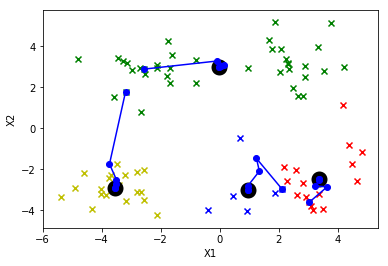

In [5]:
#可视化一下质心的变化和最后质心的位置  、 以及分类的结果
#你会发现，每次运行上面的结果，都会产生一点差异，这是因为
#1.随机选取质心  2.K的不同 都会影响kmeans聚类的结果
#besides:k应该选取多少？  
#缺点，容易收敛到局部最少值，在大数据集收敛较慢
idx0 = np.where(idx[:,0]==0)
idx1 = np.where(idx[:,0]==1)
idx2 = np.where(idx[:,0]==2)
idx3 = np.where(idx[:,0]==3)
plt.scatter(x[idx0,0],x[idx0,1],marker='x',color = 'r')
plt.scatter(x[idx1,0],x[idx1,1],marker='x',color = 'g')
plt.scatter(x[idx2,0],x[idx2,1],marker='x',color = 'y')
plt.scatter(x[idx3,0],x[idx3,1],marker='x',color = 'b')
plt.scatter(centroids[:,0],centroids[:,1],marker='o',color = 'black',linewidths=10)
K = 4
for k in range(K):
    plt.plot(np.array(cent["%d"%(k)])[:,0],np.array(cent["%d"%(k)])[:,1],"b-o")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


In [6]:
#二分 kmeans分类
#首先将所有点视为一个簇，然后每次一分为二，然后再将其中一个簇继续进行划分，
#选择哪个簇进行划分，取决于对其划分是否最大程度降低SSE的值（sum of square error 误差平方和）


xx = load_data("kmeans/testSet2.txt")
print xx.shape

plt.scatter(xx[:,0],xx[:,1],marker="x",color = 'red')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("the second dataset")
plt.show()


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(xx.shape)? (<ipython-input-6-80aeb74fc4ae>, line 7)

In [10]:
def biKmeans(x,k):
    m,n = x.shape
    idx = np.zeros((m,2)) #x对应的下标+平方误差
    centroid0 = np.mean(x,axis=0).tolist() #转化成list
    centList = [centroid0] #初始化一个质心
    for j in range(m): #初始的平方误差
        idx[j,1] = computeDistance(np.array(centroid0),x[j,:]) ** 2
    
    while (len(centList) < k): #直到划分k类
        lowestSSE = np.inf #无穷大
        bestCentToSplit = None
        bestNewCents = None
        bestIndex = None
        for i in range(len(centList)): 
            #遍历每一个簇,将该簇中的所有点视为一个小的数据集，进行k=2的kmeans（）划分
            data = x[idx[:,0] == i,:]
            cent,index,cent_dic = kmeans(data,2)
            SSE_split = np.sum(index[:,1]) #划分部分的SSE和
            SSE_noSplit = np.sum(idx[idx[:,0]!=i,1]) #没有划分部分的SSE和
            
            if (SSE_noSplit + SSE_split) < lowestSSE: #选择最优的划分方式
                bestCentToSplit = i
                bestNewCents = cent
                bestIndex = index.copy()  #记录最好的划分情况 这里的分类只有0/1

                lowestSSE = SSE_noSplit + SSE_split
                
        bestIndex[bestIndex[:,0]==1,0] = len(centList) #将1-->len(),即增加一个分类
        bestIndex[bestIndex[:,0]==0,0] = bestCentToSplit #将0-->划分的那个i
        centList[bestCentToSplit] = bestNewCents[0,:].tolist() #被划分的第i簇，质心改一下
        centList.append(bestNewCents[1,:].tolist()) #增加一个质心
        idx[idx[:,0] == bestCentToSplit,:] = bestIndex #被划分的第i簇，对应的下标，改成bestIndex
        #有原来的1个变成了两个    
    return np.array(centList),idx


        
    
            

(3L, 2L)
(60L, 2L)


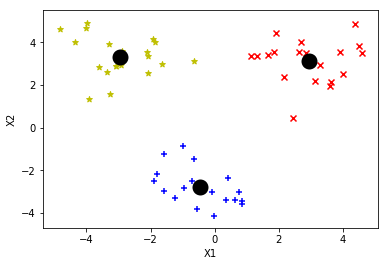

In [11]:
cent,index = biKmeans(xx,k=3)
print cent.shape
print index.shape

idx0 = np.where(index[:,0]==0)
idx1 = np.where(index[:,0]==1)
idx2 = np.where(index[:,0]==2)

plt.scatter(xx[idx0,0],xx[idx0,1],marker='x',color = 'r')
plt.scatter(xx[idx1,0],xx[idx1,1],marker='+',color = 'b')
plt.scatter(xx[idx2,0],xx[idx2,1],marker='*',color = 'y')

plt.scatter(cent[:,0],cent[:,1],marker='o',color = 'black',linewidths=10)

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [2]:
def f(x):
    return x
# Generate a slider 
interact(f, x=10);

NameError: name 'interact' is not defined